# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

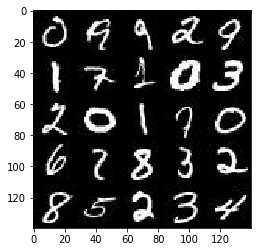

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

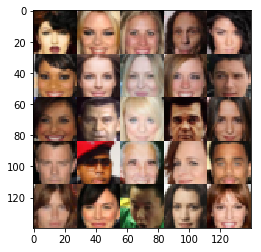

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    learning_rate_pl =tf.placeholder(tf.float32,name="learning_rate")

    return input_real,input_z,learning_rate_pl


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.15
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1,4*4*256))
        
        logits= tf.layers.dense(flattened,1)
        out= tf.sigmoid(logits)
    
        return out, logits


"""
 print("Shape 1 :{}",relu2)
 print("Shape :{}",relu3)      
        
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse_state = not is_train
    alpha = 0.15
    with tf.variable_scope('generator',reuse=reuse_state): 
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4,strides = 1, padding= 'valid' )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same')    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
   
   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list= g_vars)
        d_opt_train = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list= d_vars)
    
        return d_opt_train, g_opt_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    steps = 0
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z , learning_rate_pl = model_inputs(image_width,image_height,image_channels,z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate_pl, beta1)
    n_images = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count): 
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                
                
                
                if steps % 10 == 0 :
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,input_z:batch_z,learning_rate_pl:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,n_images,input_z,image_channels,data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.5095... Generator Loss: 0.0222
Epoch 1/2... Discriminator Loss: 2.3253... Generator Loss: 0.2403
Epoch 1/2... Discriminator Loss: 2.7746... Generator Loss: 0.1230
Epoch 1/2... Discriminator Loss: 1.5862... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.9735... Generator Loss: 0.2902
Epoch 1/2... Discriminator Loss: 2.2187... Generator Loss: 0.2231
Epoch 1/2... Discriminator Loss: 2.4744... Generator Loss: 0.1368
Epoch 1/2... Discriminator Loss: 1.8268... Generator Loss: 0.4574
Epoch 1/2... Discriminator Loss: 1.7815... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 2.1800... Generator Loss: 0.2031


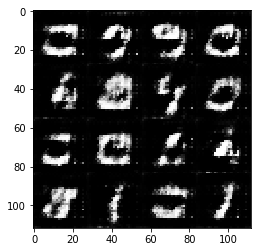

Epoch 1/2... Discriminator Loss: 1.8147... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 2.0037... Generator Loss: 0.2493
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.6947... Generator Loss: 0.3922
Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.6201... Generator Loss: 0.4494
Epoch 1/2... Discriminator Loss: 1.6524... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 2.3454... Generator Loss: 1.9635
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 0.9213


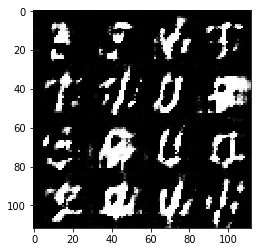

Epoch 1/2... Discriminator Loss: 1.7801... Generator Loss: 1.6032
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 1.6022... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 1.2053
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 1.1106
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.3781
Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.8521... Generator Loss: 0.3037


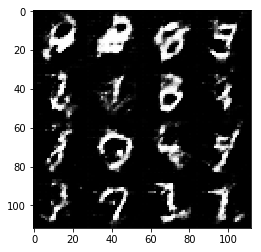

Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.6255
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 1.7017... Generator Loss: 0.3472
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.8582... Generator Loss: 0.3213
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.5244
Epoch 1/2... Discriminator Loss: 1.6775... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.9557... Generator Loss: 0.2422


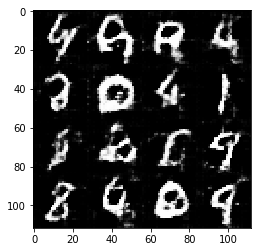

Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.5836... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.6081... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 0.4944
Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.6701... Generator Loss: 0.4211
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.9728
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.7841


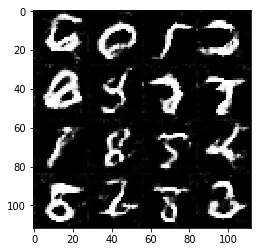

Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 1.2203
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.5560... Generator Loss: 1.2578
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.5975... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.5945
Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 1.1852


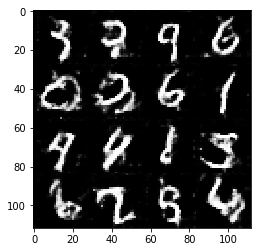

Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.8325... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.6718


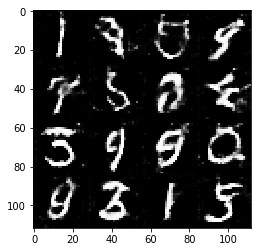

Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 1.1364
Epoch 1/2... Discriminator Loss: 1.4538... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 1.7776... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.6256... Generator Loss: 1.3791
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 1.5814... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.7434


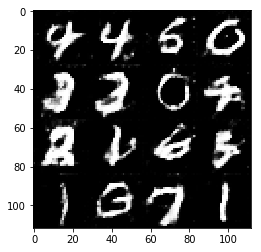

Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.8395... Generator Loss: 0.3254
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.6770... Generator Loss: 0.3458
Epoch 1/2... Discriminator Loss: 1.5859... Generator Loss: 1.3196
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 1.1625


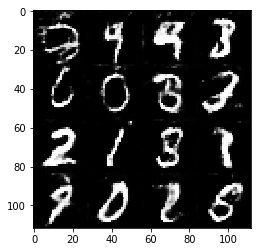

Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 1.1035
Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 1.4424
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 1.5115... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.5150... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 1.4542... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 2.0005... Generator Loss: 0.2460
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 1.0177


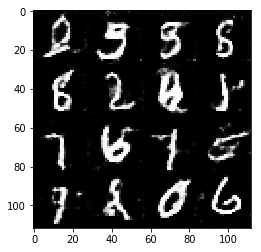

Epoch 2/2... Discriminator Loss: 1.6526... Generator Loss: 1.5496
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.5240
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 1.6102... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 1.8334... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 1.6186... Generator Loss: 0.4149
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.8068


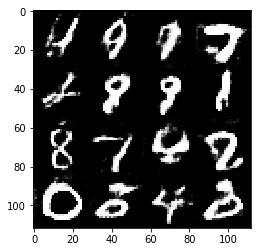

Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.4781... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.5898
Epoch 2/2... Discriminator Loss: 1.7467... Generator Loss: 0.3333
Epoch 2/2... Discriminator Loss: 1.6554... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 1.7670... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.6148... Generator Loss: 0.4318
Epoch 2/2... Discriminator Loss: 1.5231... Generator Loss: 1.2052
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.6179


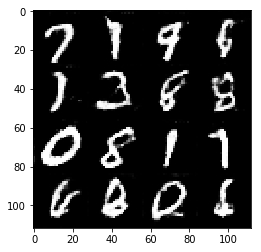

Epoch 2/2... Discriminator Loss: 1.5811... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.9751
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 1.6996... Generator Loss: 0.3727
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.8172
Epoch 2/2... Discriminator Loss: 1.5371... Generator Loss: 0.4842
Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.8106


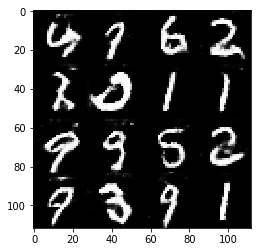

Epoch 2/2... Discriminator Loss: 1.7963... Generator Loss: 0.3430
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.7886
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.6463
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.7354


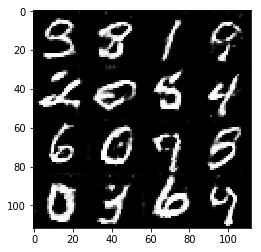

Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.6803... Generator Loss: 0.3642
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.4150
Epoch 2/2... Discriminator Loss: 1.7098... Generator Loss: 0.3613
Epoch 2/2... Discriminator Loss: 1.2754... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.6946... Generator Loss: 0.3718
Epoch 2/2... Discriminator Loss: 1.5995... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.5311... Generator Loss: 0.5539


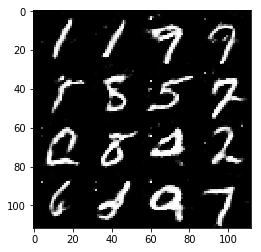

Epoch 2/2... Discriminator Loss: 1.6896... Generator Loss: 0.3891
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.4577... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 1.8464... Generator Loss: 0.2975
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.7624... Generator Loss: 0.3206
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.6393


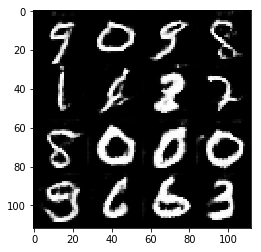

Epoch 2/2... Discriminator Loss: 1.8175... Generator Loss: 0.3172
Epoch 2/2... Discriminator Loss: 1.7047... Generator Loss: 0.3563
Epoch 2/2... Discriminator Loss: 1.7404... Generator Loss: 0.3162
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 1.8584... Generator Loss: 1.5281
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 1.1258
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.5625
Epoch 2/2... Discriminator Loss: 1.7628... Generator Loss: 0.3217
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.6003


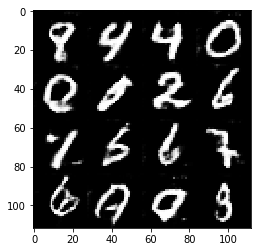

Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 1.1316
Epoch 2/2... Discriminator Loss: 1.6433... Generator Loss: 0.3908
Epoch 2/2... Discriminator Loss: 1.9360... Generator Loss: 0.2715
Epoch 2/2... Discriminator Loss: 1.6782... Generator Loss: 0.3815
Epoch 2/2... Discriminator Loss: 1.7681... Generator Loss: 0.3353
Epoch 2/2... Discriminator Loss: 1.5589... Generator Loss: 0.4502
Epoch 2/2... Discriminator Loss: 1.7042... Generator Loss: 1.1704


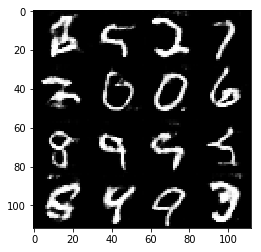

Epoch 2/2... Discriminator Loss: 1.6129... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 1.8960... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 1.5187... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 2.0625... Generator Loss: 0.2418


In [12]:
batch_size = 64
z_dim = 130
learning_rate = 0.0035
beta1 = 0.20


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3198... Generator Loss: 0.0313
Epoch 1/1... Discriminator Loss: 2.7604... Generator Loss: 0.1875
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 2.6453
Epoch 1/1... Discriminator Loss: 2.1257... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 2.0209... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.8990... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.7917


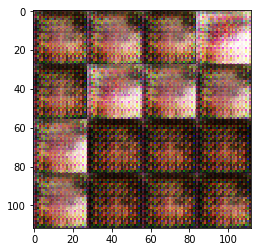

Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.7243... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.9105... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.7085


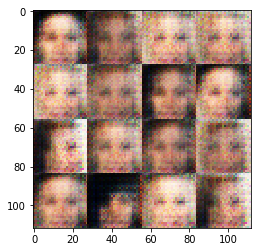

Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7815


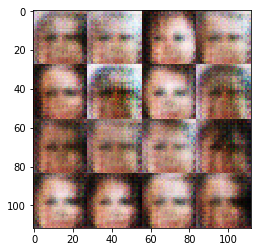

Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.7344


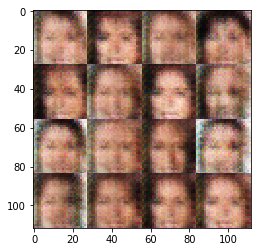

Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.7350... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7259


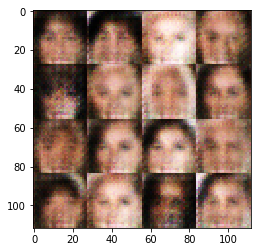

Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7868


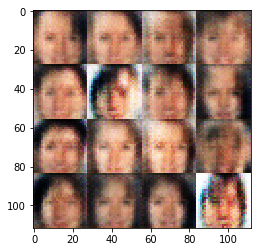

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7969


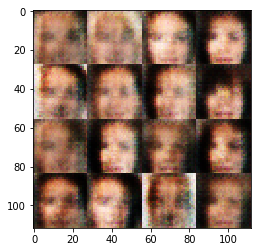

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8140


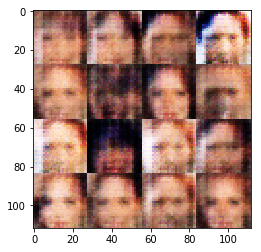

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7505


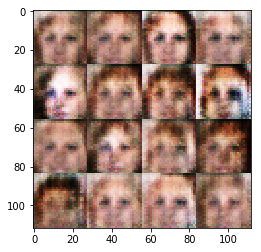

Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8007


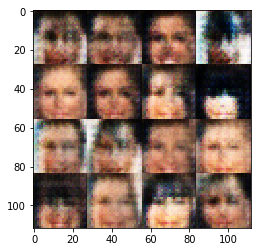

Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.7228


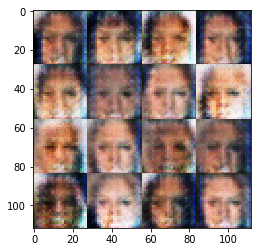

Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8335


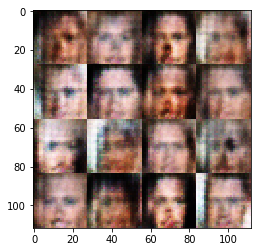

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7748


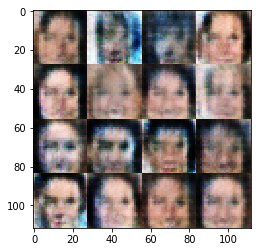

Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8228


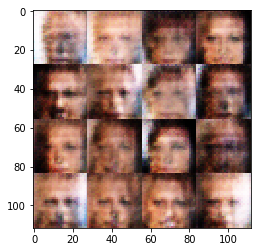

Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7798


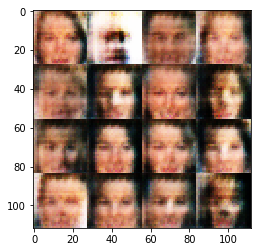

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7616


In [13]:
batch_size = 128
z_dim = 150
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.